# COMPUTER VISION AND PATTERN RECOGNITION PROJECT
## Alessandro Cesa

In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import copy

In [2]:
%%capture
!wget -c https://github.com/AlessandroCesaTs/Computer_Vision_Project_Cesa/archive/main/CVPR2023_project_2_and_3_data.zip
!unzip CVPR2023_project_2_and_3_data.zip

In [3]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [4]:
def resize_transformation(img):
  resize = transforms.Compose([transforms.Resize([64,64]),
  transforms.ToTensor(),transforms.Grayscale()])
  i = resize(img)
  i =i*255.0 #back to 0-255
  return i

In [5]:
train_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/train"
test_path = "Computer_Vision_Project_Cesa-main/CVPR2023_project_2_and_3_data/test"

In [6]:
train=ImageFolder(root=train_path,transform=resize_transformation)
test=ImageFolder(root=test_path,transform=resize_transformation)

In [7]:
#build the network

class simpleCNN(nn.Module):
  def __init__(self):
    super(simpleCNN,self).__init__() #initialize the model

    self.conv1=nn.Conv2d(in_channels=1,out_channels=8,kernel_size=3,stride=1) #Output image size is (size+2*padding-kernel)/stride -->62*62
    self.relu1=nn.ReLU()
    self.maxpool1=nn.MaxPool2d(kernel_size=2,stride=2) #outtput image 62/2-->31*31

    self.conv2=nn.Conv2d(in_channels=8,out_channels=16,kernel_size=3,stride=1) #output image is 29*29
    self.relu2=nn.ReLU()
    self.maxpool2=nn.MaxPool2d(kernel_size=2,stride=2) #output image is 29/2-->14*14  (MaxPool2d approximates size with floor)

    self.conv3=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1) #output image is 12*12
    self.relu3=nn.ReLU()

    self.fc1=nn.Linear(32*12*12,15) #16 channels * 16*16 image (64*64 with 2 maxpooling of stride 2), 15 output features=15 classes

  def forward(self,x):
    x=self.conv1(x)
    x=self.relu1(x)
    x=self.maxpool1(x)

    x=self.conv2(x)
    x=self.relu2(x)
    x=self.maxpool2(x)

    x=self.conv3(x)
    x=self.relu3(x)

    x=x.view(-1,32*12*12)

    x=self.fc1(x)

    return x

In [8]:
def init_weights(m):
  if isinstance(m,nn.Conv2d) or isinstance(m,nn.Linear):
    nn.init.normal_(m.weight,0,0.01)
    nn.init.zeros_(m.bias)

In [9]:
def train_one_epoch(epoch_index,loader):
  running_loss=0

  for i, data in enumerate(loader):

    inputs,labels=data #get the minibatch
    inputs, labels = inputs.cuda(), labels.cuda()

    outputs=model(inputs) #forward pass

    loss=loss_function(outputs,labels) #compute loss
    running_loss+=loss.item() #sum up the loss for the minibatches processed so far

    optimizer.zero_grad() #reset gradients
    loss.backward() #compute gradient
    optimizer.step() #update weights

  return running_loss/(i+1) # average loss per minibatch


In [10]:
%%capture
"""
# check the dataset size
print(f"Train size: {len(train)}")
print(f"Test size: {len(test)}")
print(train.classes)
"""

In [11]:
%%capture
"""
# get image no. 1 and its label
index=1
img,label=train[index]

print(f"label: {label}")

print("class: " + train.classes[label])
# display
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)
"""

In [12]:
np.random.seed(123)
torch.manual_seed(123)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
if device.type == 'cuda':
    torch.cuda.empty_cache()

In [13]:
#split training set into training and validation
train_size=int(0.85*len(train))
validation_size=len(train)-train_size
training_set,validation_set=torch.utils.data.random_split(train,[train_size,validation_size])

In [14]:
# Create data loaders.
# Data loaders are basically objects that make easy to iterate through the data by batches of some batch_size
batch_size = 32
train_loader = DataLoader(training_set, batch_size=batch_size,shuffle=True,pin_memory=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size,shuffle=False,pin_memory=True)
test_loader = DataLoader(test, batch_size=batch_size,shuffle=False,pin_memory=True)

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
validation_loader = DeviceDataLoader(validation_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
%%capture
"""
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break
"""

In [17]:
%%capture
"""
# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())
"""

In [18]:
%%capture
"""
classes=train.classes

# get a batch from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)   #images is a (batch_size,3,32,32) tensor

print(images.size())

img=torchvision.utils.make_grid(images)
figure = plt.figure()
plt.imshow(img.numpy().transpose((1, 2, 0)).astype(np.uint8),cmap='gray') #<< swap axes because img is (3,H,W) but imshow() expects (H,W,3)

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
"""

In [19]:
%%capture
"""
# display the last image only
figure = plt.figure()
plt.imshow(images[-1,:,:,:].numpy().transpose((1,2,0)),cmap='gray')
print(f'{train.classes[labels[-1]]:5s}')
"""

In [20]:
# Instantiate the model
model = simpleCNN()
model.to(device)
model.apply(init_weights)
loss_function=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# Print the model summary
#print(model)

EPOCH1:
LOSS train: 2.7080280065536497 validation: 2.707507610321045 | validation_accuracy: 6.666666666666667% 
EPOCH2:
LOSS train: 2.7064559876918795 validation: 2.705883026123047 | validation_accuracy: 5.777777777777778% 
EPOCH3:
LOSS train: 2.700666534900665 validation: 2.6924655437469482 | validation_accuracy: 7.555555555555555% 
EPOCH4:
LOSS train: 2.6834333658218386 validation: 2.641897201538086 | validation_accuracy: 12.0% 
EPOCH5:
LOSS train: 2.651807487010956 validation: 2.6364219188690186 | validation_accuracy: 10.222222222222221% 
EPOCH6:
LOSS train: 2.5934670209884643 validation: 2.491793632507324 | validation_accuracy: 15.555555555555555% 
EPOCH7:
LOSS train: 2.58232986330986 validation: 2.550381660461426 | validation_accuracy: 14.222222222222221% 
EPOCH8:
LOSS train: 2.496866595745087 validation: 2.5013370513916016 | validation_accuracy: 14.222222222222221% 
EPOCH9:
LOSS train: 2.4514476001262664 validation: 2.4652066230773926 | validation_accuracy: 16.0% 
EPOCH10:
LOSS t

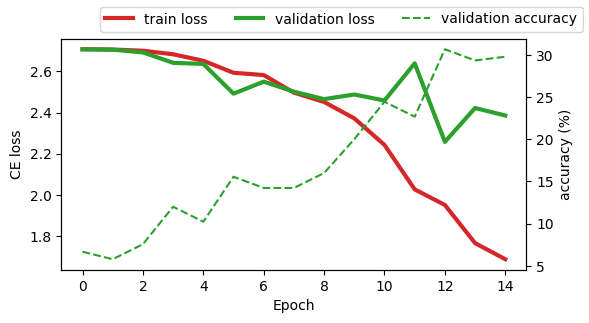

In [21]:
EPOCHS=15

best_validation_loss=np.inf

train_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(EPOCHS):
  print('EPOCH{}:'.format(epoch+1))

  model.train(True)
  train_loss=train_one_epoch(epoch,train_loader)

  running_validation_loss=0.0

  model.eval()

  with torch.no_grad(): # Disable gradient computation and reduce memory consumption
    correct=0
    total=0
    for i,vdata in enumerate(validation_loader):
      vinputs,vlabels=vdata
      voutputs=model(vinputs)
      _,predicted=torch.max(voutputs.data,1)
      vloss=loss_function(voutputs,vlabels)
      running_validation_loss+=vloss
      total+=vlabels.size(0)
      correct+=(predicted==vlabels).sum().item()
  validation_loss=running_validation_loss/(i+1)
  validation_acc = 100*correct/total
  print(f'LOSS train: {train_loss} validation: {validation_loss} | validation_accuracy: {validation_acc}% ')

  if validation_loss<best_validation_loss: #save the model if it's the best so far
    timestamp=datetime.now().strftime('%Y%m%d_%H%M%S')
    best_validation_loss=validation_loss
    model_path='model_{}_{}'.format(timestamp,epoch)
    torch.save(model.state_dict(),model_path)

  train_losses.append(train_loss)
  validation_losses.append(validation_loss)
  validation_accuracies.append(validation_acc)


plt.plot(train_losses, color='tab:red', linewidth=3, label='train loss')
validation_losses_np = torch.stack(validation_losses).cpu().numpy() #move validation losses to cpu to plot with matplotlib
plt.plot(validation_losses_np, color='tab:green', linewidth=3, label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('CE loss')

ax_right = plt.gca().twinx()
#validation_accuracies_np = torch.stack(validation_accuracies).cpu().numpy() #move validation accuracies to cpu to plot with matplotlib
ax_right.plot(validation_accuracies, color='tab:green', linestyle='--', label='validation accuracy')
ax_right.set_ylabel('accuracy (%)')

plt.gcf().legend(ncol=3)
plt.gcf().set_size_inches(6, 3)


In [22]:
#load the best model and evaluate performance on the test set

newModel=simpleCNN()
newModel.to(device)
newModel.load_state_dict(torch.load(model_path))

correct=0
total=0

with torch.no_grad():
  for data in test_loader:
    images,labels=data
    images, labels = images.cuda(), labels.cuda()
    outputs=newModel(images)
    _,predicted=torch.max(outputs.data,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum().item()

print(f"Accuracy of the network on the test images: {100*correct/total}%")

Accuracy of the network on the test images: 26.934673366834172%


In [23]:
!rm model*